In [3]:
import numpy as np
import os 
from numpy import random, exp, zeros
import numba
import matplotlib.pyplot as plt
import timeit
import os
# from PyMake import PyMake

In [4]:
class RustMonteCarloData:
    def __init__(self, name):
        self.name = name
        self.time = None
        self.temp = []
        self.E    = []
        self.mag  = []
        self.spec_heat   = []
        self.mag_suscept = []
        
    def init_observables(self):
        with open(self.name, "r") as file:
            for n, lines in enumerate(file):
                if n!= 0:
                    slines = lines.split(", ")
                    self.temp.append(float(slines[0]))
                    self.E.append(float(slines[1]))
                    self.mag.append(float(slines[2]))
                    self.spec_heat.append(float(slines[3]))
                    self.mag_suscept.append(float(slines[4]))
                # else:
                #     self.time = float(str(lines))

In [5]:
class NumbaMonteCarloData:
    def __init__(self, energies, magnetizations, energies_sqr, magnetizations_sqr):
        self.temp        = None
        self.E           = None
        self.mag         = None
        self.spec_heat   = None
        self.mag_suscept = None
        self.time        = None
        self.energies           = energies
        self.energies_sqr       = energies_sqr
        self.magnetizations     = magnetizations
        self.magnetizations_sqr = magnetizations_sqr

    def set_time(self, my_time):
        self.time = my_time

    def set_num_spins(self, my_N):
        self.N = my_N

    def set_temp(self, my_temp_vec):
        self.temp = my_temp_vec
        
    def init_observables(self):
        self.E           = self.energies / self.N
        self.mag         = self.magnetizations / self.N
        self.spec_heat   = (self.energies_sqr - self.energies**2) / (self.N * self.temp * self.temp)
        self.mag_suscept = (self.magnetizations_sqr - self.magnetizations**2) / (self.N * self.temp)

## Ising  metropolis: 

In [6]:
numba.set_num_threads(8)

In [7]:
@numba.jit
def generate_polarized_2d_ising_spins(L):
    return np.ones((L, L), dtype=np.int32)


@numba.jit
def Compute_Metropolis_energy_delta(Mat, x, L, J):
    (i,j) = x
    delta_E = 2*J*Mat[i,j] * (  Mat[i,(j+1)%L] + Mat[i,(j-1)%L] + Mat[(i+1)%L,j] + Mat[(i-1)%L,j]   )
    return delta_E

@numba.jit
def get_energy(spin, J):
    E = 0
    L = len(spin)
    for i in range(L):
        for j in range(L):
            E += -J*spin[i,j]*( spin[(i+1)%L,j] + spin[i,(j-1)%L]  )
    return E

@numba.jit
def perform_mc_proposal(spin,T,J):
    L = len(spin)
    x_r = ( random.randint(0,L), random.randint(0,L) )
    dE = Compute_Metropolis_energy_delta(spin,x_r,L,J)
    if dE < 0 or random.random() < exp(-dE/T):
        spin[x_r] *= -1
        dS = 2*spin[x_r]
        return (dE, dS)
    else:
        return (0,0)
    
@numba.jit
def perform_metropolis_sweep(spin, T, J):
    N = len(spin)**2
    (dE, dS) = (0., 0.)
    for _ in range(N):
        (dE_temp, dS_temp) = perform_mc_proposal(spin, T, J)
        dE += dE_temp
        dS += dS_temp
    return (dE, dS)

Convention: 1 sweep = One pass across the lattice = N updates => each spin is 'hit' once. Makes comparison with other algorithms easier.

In [8]:
@numba.jit(parallel=True)
def perform_ising_metropolis_parallel(L: int, J: float, temp_vec: np.ndarray, MCS_thermalization_steps: int, MCS_measures:int):
    # N             = int(L*L)
    measure_steps = 1                               #Finish full lattice sweeps between measurements => reduces correlation between measurements.
    # N_measures    = int(N*MCS_measures/measure_steps)

    energies            = zeros( len(temp_vec), dtype=np.float64)
    magnetizations      = zeros( len(temp_vec), dtype=np.float64)
    magnetizations_sqr  = zeros( len(temp_vec), dtype=np.float64)
    energies_sqr        = zeros( len(temp_vec), dtype=np.float64)
    for t in numba.prange(len(temp_vec)):

        temp = temp_vec[t]
        spin = generate_polarized_2d_ising_spins(L)
        if temp == 0.:
            temp = 1e-6
        
        E  = 0.
        M  = 0.
        E2 = 0.
        M2 = 0.
        for _ in range(int(MCS_thermalization_steps)):
            perform_metropolis_sweep(spin,temp,J)
        
        my_energy =  get_energy(spin,J)
        my_mag    =  np.sum(spin)
        n = 0
        for step in range(int(MCS_measures)):            
            (dE, dS) = perform_metropolis_sweep(spin,temp,J)
            
            my_energy += dE
            my_mag    += dS
            if step%measure_steps == 0:
                E  += my_energy  / MCS_measures
                M  += np.abs(my_mag)  / MCS_measures
                E2 += (my_energy**2)  / MCS_measures
                M2 += (np.abs(my_mag)**2)  / MCS_measures


        energies[t]           = E 
        magnetizations[t]     = M
        energies_sqr[t]       = E2
        magnetizations_sqr[t] = M2

    # NumbaMonteCarloData()
    return  energies, magnetizations, energies_sqr, magnetizations_sqr

In [17]:
L = 10
N = L**2
J = 1.0
MCS_thermalization = 5e5
MCS_measures       = 5e5

temp_vec = np.array([1+0.05*n for n in range(40)])

start = timeit.default_timer()
numba_output = NumbaMonteCarloData(     *perform_ising_metropolis_parallel(L, J, temp_vec, MCS_thermalization, MCS_measures)    )
stop = timeit.default_timer()

numba_time = (stop-start)
numba_output.set_time(numba_time)
numba_output.set_num_spins(N)
numba_output.set_temp(temp_vec)
numba_output.init_observables()

print(f"Python Numba! Simulation for N={L}^2 spins for {len(temp_vec)} temperature values from {temp_vec[0]:.3} to {temp_vec[len(temp_vec)-1]:.3}).")
print(f"Num of threads {numba.get_num_threads()}")
print(f"time take is {numba_time:.3f}s")

Python Numba! Simulation for N=10^2 spins for 40 temperature values from 1.0 to 2.95).
Num of threads 8
time take is 114.009s


#### Save the numba measurements

Save the measurements:

In [11]:
L = 10
rust_result = RustMonteCarloData(f"montecarlo_parallel_10x10_temp_1.00_to_3.00.txt")
rust_result.init_observables()
# plt.scatter(rust_result.temp, rust_result.mag, s=15, c='r', marker= 'x', label="Rust")
# rust_result.mag[0]

### Plot!

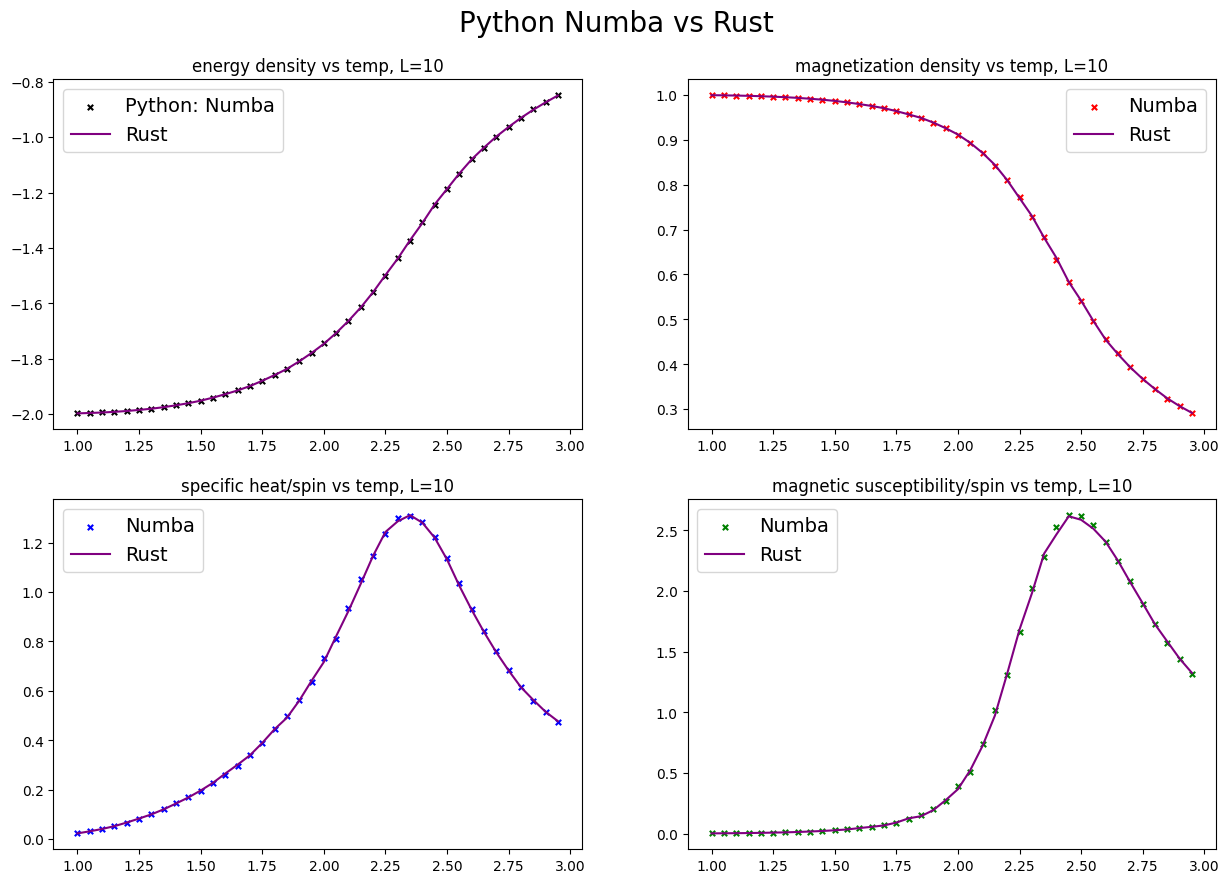

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

fig.suptitle(f"Python Numba vs Rust", y=0.95, fontsize=20)

ax1.scatter(numba_output.temp, numba_output.E, s=15, c='k', marker= 'x', label="Python: Numba")
ax1.plot(rust_result.temp, rust_result.E, c='purple', label="Rust" )
ax1.set_title(f"energy density vs temp, L={L}")
ax1.legend(loc="upper left",fontsize=14)

ax2.scatter(numba_output.temp, numba_output.mag, s=15, c='r', marker= 'x', label="Numba")
ax2.plot(rust_result.temp, rust_result.mag, c='purple', label="Rust")
ax2.set_title(f"magnetization density vs temp, L={L}")
ax2.legend(loc="upper right",fontsize=14)

ax3.scatter(numba_output.temp, numba_output.spec_heat, s=15, c='b', marker= 'x', label="Numba")
ax3.plot(rust_result.temp, rust_result.spec_heat, c='purple', label="Rust")
ax3.set_title(f"specific heat/spin vs temp, L={L}")
ax3.legend(loc="upper left",fontsize=14)

ax4.scatter(numba_output.temp, numba_output.mag_suscept, s=15, c='g', marker= 'x', label="Numba")
ax4.plot(rust_result.temp, rust_result.mag_suscept, c='purple', label="Rust")
ax4.set_title(f"magnetic susceptibility/spin vs temp, L={L}")
ax4.legend(loc="upper left",fontsize=14)